In [1]:
from b_field import structured_field
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
%matplotlib notebook
def field_line(x_0, steps, ds):
    x = np.zeros((steps, 3))
    x[0] = x_0
    for i in range(steps-1):
        x[i+1] = integrate(x[i], ds)
    return x

def integrate(x_prev, ds):
    # give x_prev in cartesian
    #print('x_prev', x_prev)
    r, theta, phi = cart_to_sphere(x_prev[0], x_prev[1], x_prev[2])
    #print('sph_coords', r, theta, phi)
    B_sph = B_sphere(r, theta, phi)
    B_cart = np.matmul(trafo(r, theta, phi), B_sph.transpose()).transpose()
    #print(B_cart, B_cart.shape)
    norm = np.linalg.norm(B_cart)
    #print(norm, norm.shape)
    #print(B_cart / norm * ds)
    x_new = x_prev + B_cart / norm * ds
    #print(x_new, x_new.shape)
    #print('new x', x_new)
    return x_new


def cart_to_sphere(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)
    return r, theta, phi

def sphere_to_cart(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z


alpha = 5.7634591968
c = 1
F_0 = c * (alpha * np.cos(alpha) - np.sin(alpha)) * alpha**2


def trafo(r, theta, phi):
    '''Returns trafo used for vector fields, i.e. Field A cartesian = S * Field A spherical. S is returned'''
    #shape = r.shape
    #outdata = np.zeros((r.shape[0] * r.shape[1] * r.shape[2], 3, 3))
    #rf, thetaf, phif = r.flatten(), theta.flatten(), phi.flatten()
    #for c, val in enumerate(rf):
    mat = np.array([[np.sin(theta) * np.cos(phi), np.cos(theta) * np.cos(phi), -np.sin(phi)],
                    [np.sin(theta) * np.sin(phi), np.cos(theta) * np.sin(phi), np.cos(phi)],
                    [np.cos(theta), -np.sin(theta), 0]])
        #outdata[c, :, :] = mat[:, :]
    
    return mat

def b_r(r, theta):
    '''
    zero_val = - np.cos(theta) * (6 * F_0 + 2 * alpha**5 * c) / (3 * alpha**2)
    if np.any(np.isclose(r, 0)):
        try:
            zero_args = np.argwhere(np.isclose(r, 0))
            val = 2 * np.cos(theta) * f(r) / r**2
            val[zero_args] = zero_val
        except TypeError:
            val = zero_val
    else:
    '''
    val = 2 * np.cos(theta) * f(r) / r**2
    return val
    

def b_theta(r, theta):
    '''
    zero_val = np.sin(theta) * (6 * F_0 + 2 * alpha**5 * c) / (3 * alpha**2)
    if np.any(np.isclose(r, 0)):
        try:
            zero_args = np.argwhere(np.isclose(r, 0))
            val = - np.sin(theta) * f_prime(r) / r
            val[zero_args] = zero_val
        except TypeError:
            val = zero_val
    else:
    '''
    val = - np.sin(theta) * f_prime(r) / r
    return val


def b_phi(r, theta):
    '''
    zero_val = 0
    if np.any(np.isclose(r, 0)):
        try:
            zero_args = np.argwhere(np.isclose(r, 0))
            val =  alpha * np.sin(theta) * f(r) / r
            val[zero_args] = zero_val
        except TypeError:
            val = zero_val
    else:
    '''
    val = alpha * np.sin(theta) * f(r) / r
    return val


def f(r):
    return c * (alpha * np.cos(alpha * r) - np.sin(alpha * r) / r) \
           - F_0 * r**2 / alpha**2


def f_prime(r):
    return c * ( - alpha**2 * np.sin(alpha * r) \
                - alpha * np.cos(alpha * r) / r \
                + np.sin(alpha * r) / r**2) \
               - 2 * F_0 * r / alpha**2

def B_sphere(r, theta, phi):
    return np.array([[b_r(r, theta), b_theta(r, theta), b_phi(r, theta)]])


def norm(r):
    return np.sqrt(r[:, :, :, 0]**2)



<IPython.core.display.Javascript object>


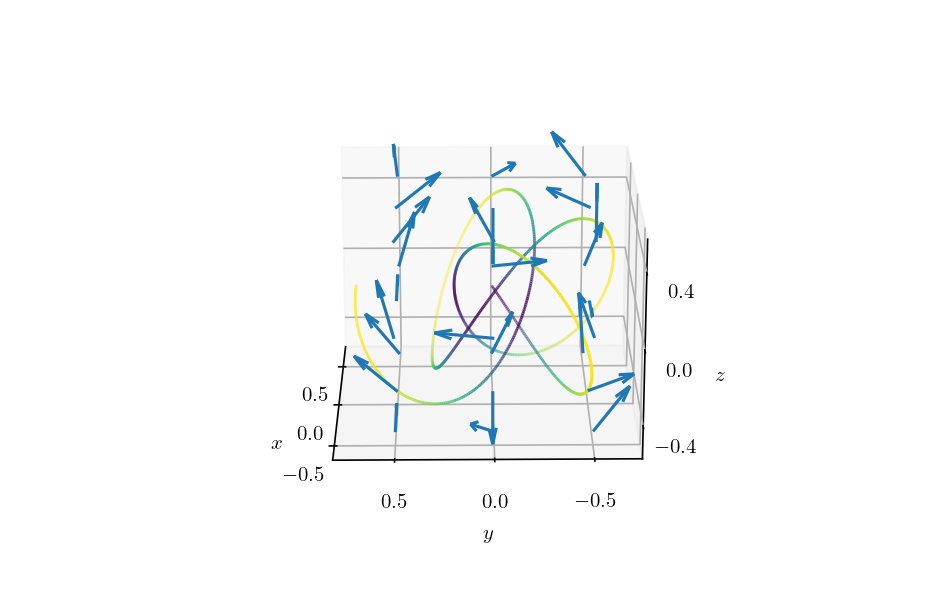

/home/julian/anaconda3/envs/fermi3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/julian/anaconda3/envs/fermi3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in double_scalars
/home/julian/anaconda3/envs/fermi3/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in double_scalars
/home/julian/anaconda3/envs/fermi3/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in double_scalars


[[ 2.00000000e-01  0.00000000e+00  1.22464680e-17]
 [ 2.00000000e-01 -5.55862979e-04 -8.31273931e-04]
 [ 1.99999009e-01 -1.11172729e-03 -1.66254638e-03]
 ...
 [-2.41043481e-02  7.05010138e-01  9.94067922e-02]
 [-2.37183262e-02  7.04868386e-01  1.00318326e-01]
 [-2.33322025e-02  7.04725003e-01  1.01229561e-01]]


In [3]:
# init figure
fig = plt.figure()
ax = fig.gca(projection='3d')


# init grid values, num=numbers per axis, max_r cutoff for field values at radius max_r
num = 5
max_r = 1

# init grid coords
x = np.linspace(-1, 1, num=num)
y = np.linspace(-1, 1, num=num)
z = np.linspace(-1, 1, num=num)
X, Y, Z = np.meshgrid(x, y, z)
R, THETA, PHI = cart_to_sphere(X, Y, Z)

# create mask for coords
R_m = np.ma.array(R)
R_m = np.ma.masked_where(R_m > 0.98, R_m)

# apply mask to coords
X_m = np.ma.array(X, mask=R_m.mask)
Y_m = np.ma.array(Y, mask=R_m.mask)
Z_m = np.ma.array(Z, mask=R_m.mask)

# create mask for B field
R_m = np.zeros((num, num, num, 3))
R_m[:, :, :, 0] = R
R_m = np.ma.array(R_m)
R_m = np.ma.masked_where(R_m > 1, R_m)


matrices = np.zeros((num**3, 3, 3))
B_sph = np.zeros((num**3, 3))
B_cart = np.zeros((num**3, 3))
for c, (r, theta, phi) in enumerate(zip(R.reshape((num**3)), THETA.reshape((num**3)), PHI.reshape((num**3)))):
    #print(c, r, theta, phi)
    matrices[c, :, :] = trafo(r, theta, phi)
    B_sph[c, :] = B_sphere(r, theta, phi)
    B_cart[c, :] = np.matmul(matrices[c, :, :], B_sph[c, :])
meshgrid_trafos = matrices.reshape((num, num, num, 3, 3))
meshgrid_B_sph = B_sph.reshape((num, num, num, 3))
meshgrid_B_cart = B_cart.reshape((num, num, num, 3))
norm = np.linalg.norm(meshgrid_B_cart, axis=-1)

mesh_B_cart_m = np.ma.array(meshgrid_B_cart, mask=R_m.mask)

ax.quiver(X_m, Y_m, Z_m, mesh_B_cart_m[:, :, :, 0] / norm, mesh_B_cart_m[:, :, :,1] / norm, mesh_B_cart_m[:, :, :, 2] / norm,
          length=0.3, pivot='tail')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')




# plot field arrows on sphere of r=0.5
r = 0.2
theta = np.linspace(0, np.pi, num=10)
phi = np.linspace(0, 2 * np.pi, num=10)
R, THETA, PHI = np.meshgrid(r, theta, phi)
X, Y, Z = sphere_to_cart(R, THETA, PHI)
matrices = np.zeros((R.flatten().shape[0], 3, 3))
B_sph = np.zeros((R.flatten().shape[0], 3))
B_cart = np.zeros((R.flatten().shape[0], 3))
for c, (r, theta, phi) in enumerate(zip(R.flatten(), THETA.flatten(), PHI.flatten())):
    matrices[c, :, :] = trafo(r, theta, phi)
    B_sph[c, :] = B_sphere(r, theta, phi)
    B_cart[c, :] = np.matmul(matrices[c, :, :], B_sph[c, :])
meshgrid_trafos = matrices.reshape((R.shape[0], R.shape[1], R.shape[2], 3, 3))
meshgrid_B_sph = B_sph.reshape((R.shape[0], R.shape[1], R.shape[2], 3))
meshgrid_B_cart = B_cart.reshape((R.shape[0], R.shape[1], R.shape[2], 3))
norm = np.linalg.norm(meshgrid_B_cart, axis=-1)
#ax.quiver(X, Y, Z, meshgrid_B_cart[:, :, :, 0] / norm, meshgrid_B_cart[:, :, :,1] / norm, meshgrid_B_cart[:, :, :, 2] / norm,
#          length=0.3, pivot='middle')

# plot a single field line from the "ODE solver" defined in field_line()
for phi in np.linspace(0, 2 * np.pi, num=1):
    x_0 = sphere_to_cart(0.2, np.pi / 2, phi)
    x = field_line(x_0, 10000, 0.001)
    print(x)
    line = ax.scatter(x[::10, 0], x[::10, 1], x[::10, 2], c=np.linalg.norm(x[::10], axis=-1), cmap=plt.get_cmap('viridis'), s=1, marker='.')
#cbar = fig.colorbar(line, ax=ax, cmap=plt.cm.jet, label='$r$')
ax.set_xticks((-0.5, 0, 0.5))
ax.set_yticks((-0.5, 0, 0.5))
ax.set_zticks((-0.4, 0, 0.4))
ax.view_init(elev=25, azim=-107)

# plot the equator at r=0.5
phi = np.linspace(0, 2*np.pi, num=1000)
r = np.full((1000), 0.5)
theta = np.full((1000), np.pi / 2)
x, y, z = sphere_to_cart(r, theta, phi)
#ax.plot(x, y, z, c='black', alpha=0.5)

# plot some other lines
theta = np.full((1000), np.pi / 4)
x, y, z = sphere_to_cart(r, theta, phi)
#ax.plot(x, y, z, c='black', alpha=0.5)

theta = np.full((1000), 3 * np.pi / 4)
x, y, z = sphere_to_cart(r, theta, phi)
#ax.plot(x, y, z, c='black', alpha=0.5)
#cbar.set_clim()
#ax.scatter(*sphere_to_cart(0.5, np.pi / 2, 0))
#fig.savefig('../../../../latex/plots/3d_fieldlines_no_colorbar.png')

In [ ]:
x = np.linspace(0, 3 * np.pi, 100)
y = np.sin(x)
dydx = np.cos(0.5 * (x[:-1] + x[1:]))  # first derivative

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(dydx)
lc.set_linewidth(1)
line = axs.add_collection(lc)
fig.colorbar(line, ax=axs)


axs.set_xlim(x.min(), x.max())
axs.set_ylim(-1.1, 1.1)
plt.show()

In [ ]:
phi = 0
x_0 = sphere_to_cart(0.2, np.pi / 2, phi)
x = field_line(x_0, 10000, 0.001)

In [ ]:
x